# TestCase1 v3 - Solution inexacte sur le bord

In [23]:
# sélection du cas test
testcase = 1
version = 3
param_num = 1
degree = 1

**Idée :** On considère le TestCase1-v3.

On cherche à tester la correction en considérant que $u_\theta$ n'est pas exacte au bord. 

On testera comme conditions $\tilde{C}=0$ et $\tilde{C}=-u_\theta$ sur le bord.

## Imports + Load

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
import dolfin as df

from scimba.equations.domain import SpaceTensor
from scimba.equations import domain
from modules.solver_fem import FEMSolver
from modules.fenics_expressions import UexExpr
from modules.utils import create_tree

In [28]:
if testcase == 1:
    if version == 3:
        from modules.testcases.d2.test_1.test_1_v1_v3 import Run_laplacian2D,Poisson_2D
    else:
        raise ValueError("Version not found")
    from modules.problem import TestCase1
    problem = TestCase1()
else:
    raise ValueError("Testcase not found")

result_dir = "../../../results/2D/testcase"+str(testcase)+"/version"+str(version)
result_dir += "/nonexact_BC/"
create_tree(result_dir)

torch loaded; device is cuda


/home/flecourtier/Bureau/Article1
>> load network /home/flecourtier/Bureau/Article1/networks/test_fe1.pth
jsbdbshd
network loaded
Error  tensor([0.0025])


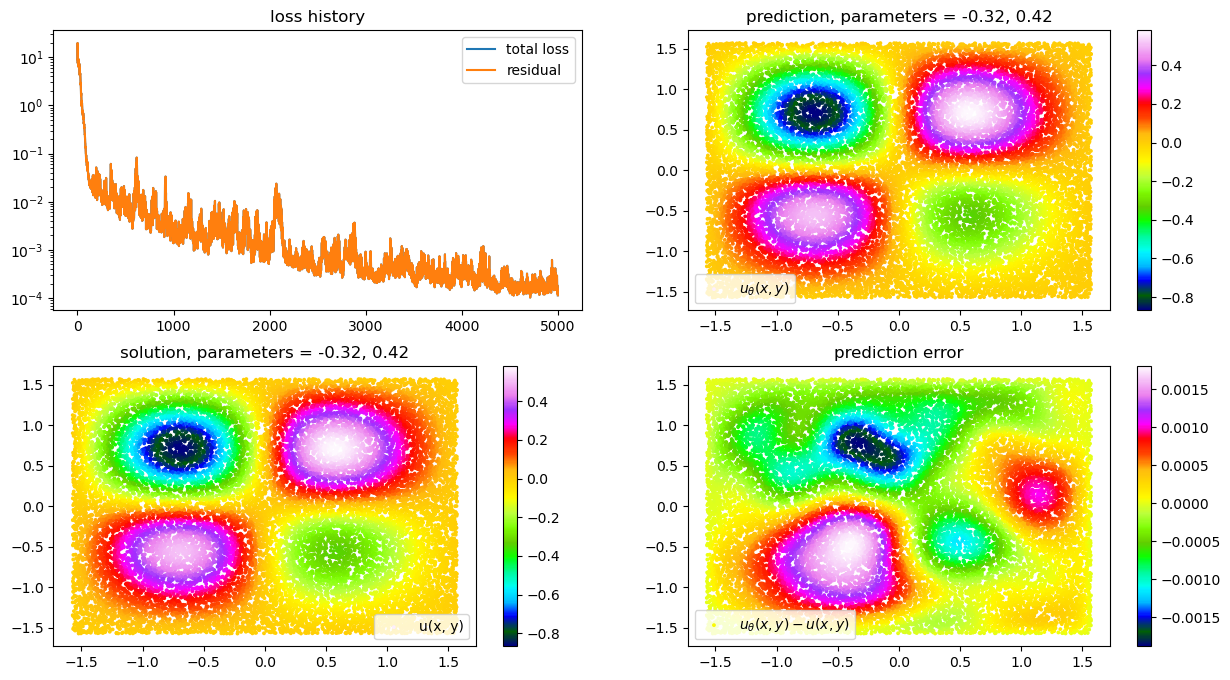

In [29]:
pde = Poisson_2D()
trainer,u_theta = Run_laplacian2D(pde)

In [30]:
def get_param(i):
    params = trainer.pde.parameter_domain.cpu().numpy()
    # pick 1 random parameter
    np.random.seed(0)
    for j in range(i):
        param = [np.random.uniform(params[0][0], params[0][1]), np.random.uniform(params[1][0], params[1][1])]
    param = np.round(param, 2)
    return param

param = get_param(param_num)
print(param)
params = [param]

[0.05 0.22]


## Test Non exact BC

In [31]:
def get_test_sample(solver,trainer,deg_PINNs):
    # get coordinates of the dof
    V_test = df.FunctionSpace(solver.mesh,"CG",deg_PINNs)
    XXYY = V_test.tabulate_dof_coordinates()
    X_test = torch.tensor(XXYY,requires_grad=True)
    X_test = SpaceTensor(X_test,torch.zeros_like(X_test,dtype=int))

    # get parameters
    nb_params = len(trainer.pde.parameter_domain)
    shape = (XXYY.shape[0],nb_params)
    if shape[1] == 0:
        mu_test = torch.zeros(shape)
    else:
        ones = torch.ones(shape)
        mu_test = (torch.mean(trainer.pde.parameter_domain, axis=1) * ones)#.to(device)

    return V_test,X_test,mu_test

In [32]:
nb_vert = 32
solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree)

degree_PINNs = 10
V_test,X_test,mu_test = get_test_sample(solver,trainer,degree_PINNs)
pred = u_theta.setup_w_dict(X_test, mu_test)
phi_tild = pred["w"][:,0].cpu().detach().numpy()

u_PINNs = df.Function(V_test)
u_PINNs.vector()[:] = phi_tild.copy()

hmax =  0.1433188044567221


In [33]:
u_ex = UexExpr(params[0], degree=degree, domain=solver.mesh, pb_considered=solver.pb_considered)

V_test_,X_test_,mu_test_ = get_test_sample(solver,trainer,degree)
pred = u_theta.setup_w_dict(X_test_, mu_test_)
phi_tild = pred["w"][:,0].cpu().detach().numpy()

u_PINNs_1 = df.Function(V_test_)
u_PINNs_1.vector()[:] = phi_tild.copy()

C_ex = df.Function(solver.V)
u_ex_inter = df.project(u_ex,solver.V)
C_ex.vector()[:] = u_ex_inter.vector()[:] - u_PINNs_1.vector()[:]

In [34]:
def plot_solution(sol,C_tild,norme_L2,title,filename=None):
    plt.figure(figsize=(15,10))

    plt.subplot(2,3,1)
    c = df.plot(C_ex)
    plt.colorbar(c)
    plt.title("C_ex")

    plt.subplot(2,3,2)
    c = df.plot(C_tild)
    plt.colorbar(c)
    plt.title("C_tild")

    plt.subplot(2,3,3)
    error = df.Function(solver.V)
    error.vector()[:] = C_ex.vector()[:] - C_tild.vector()[:]
    c = df.plot(error)
    plt.colorbar(c)
    plt.title("C_ex-C_tild")
    
    plt.subplot(2,3,4)
    c = df.plot(u_ex_inter)
    plt.colorbar(c)
    plt.title("u_ex")
    
    plt.subplot(2,3,5)
    sol_inter = df.project(sol,solver.V)
    c = df.plot(sol_inter)
    plt.colorbar(c)
    plt.title("sol")
    
    plt.subplot(2,3,6)
    error = df.Function(solver.V)
    error.vector()[:] = u_ex_inter.vector()[:] - sol_inter.vector()[:]
    c = df.plot(error)
    plt.colorbar(c)
    plt.title(f"u_ex-sol\nL2 norm : {norme_L2:.2e}")    

    plt.suptitle(title)

    if filename is not None:
        plt.savefig(filename)
    else:
        plt.show()

0.00253344845416695


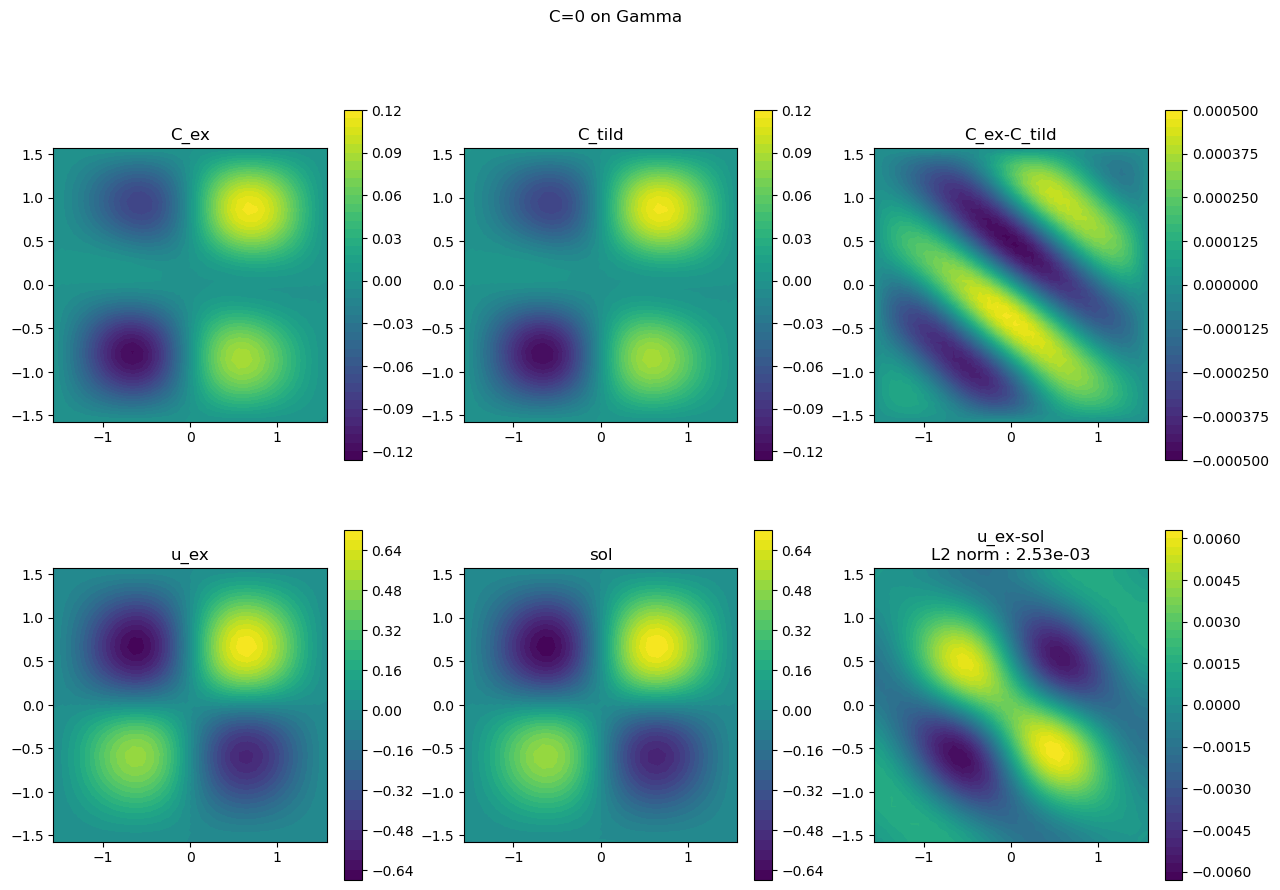

In [35]:
sol_C0,C_tild_C0,norme_L2_C0 = solver.corr_add(0,u_PINNs,nonexactBC=False)
print(norme_L2_C0)

filename = result_dir + "C0.png"
plot_solution(sol_C0,C_tild_C0,norme_L2_C0,"C=0 on Gamma",filename = filename)

0.00330970397920977


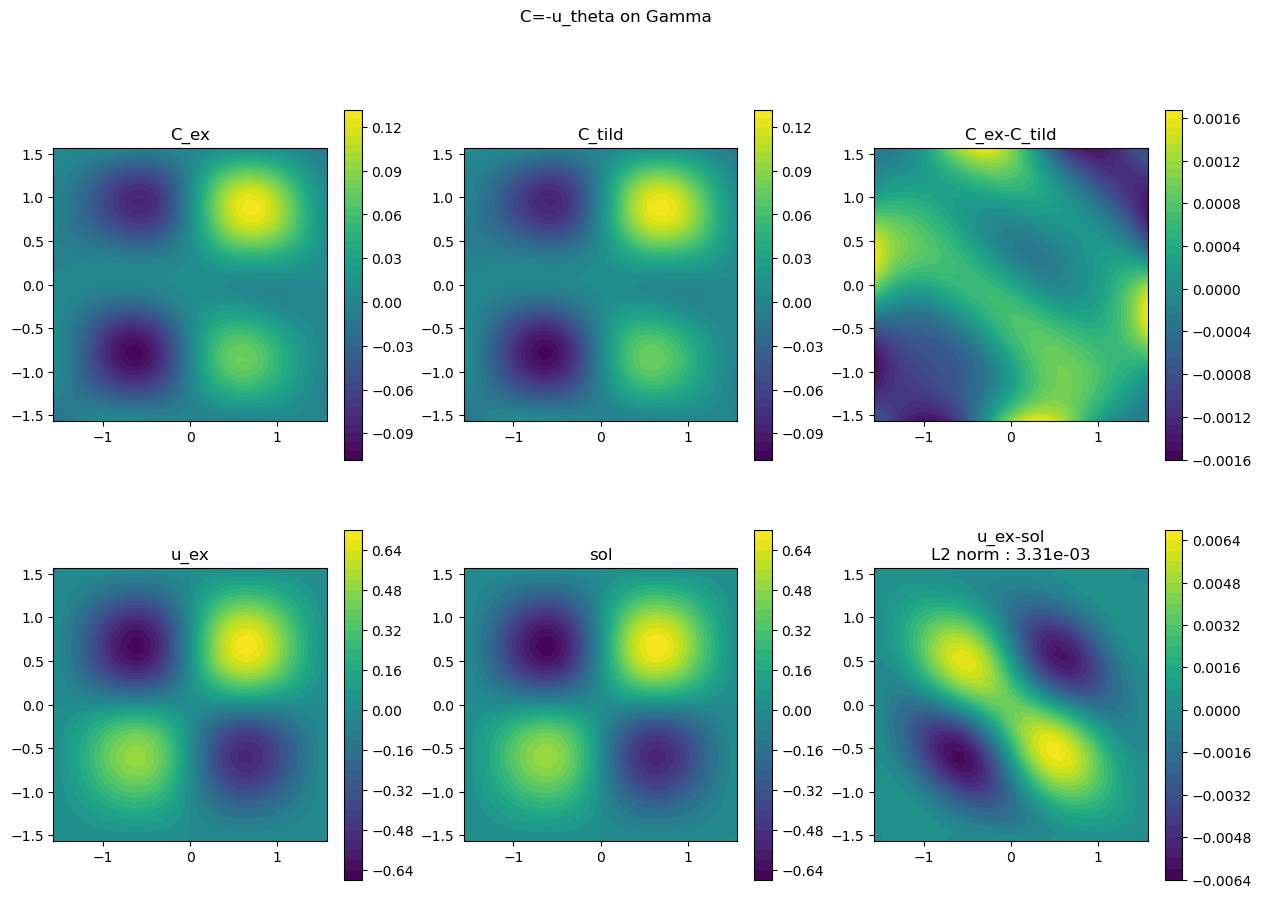

In [22]:
sol_C1,C_tild_C1,norme_L2_C1 = solver.corr_add(0,u_PINNs,nonexactBC=True)
print(norme_L2_C1)

filename = result_dir + "C-utheta.png"
plot_solution(sol_C1,C_tild_C1,norme_L2_C1,"C=-u_theta on Gamma",filename=filename)